In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = "CS231N/assignments/assignment2/"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# this downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content

Mounted at /content/drive
/content/drive/My Drive/CS231N/assignments/assignment2/cs231n/datasets
/content


# What's this PyTorch business?

Вы написали много кода в этом задании, чтобы обеспечить целый ряд функций нейронной сети. Dropout, Batch Norm и 2D-свертки являются одними из рабочих лошадок глубокого обучения в компьютерном зрении. Вы также усердно работали над тем, чтобы сделать ваш код эффективным и векторизованным. 

Однако в последней части этого задания мы собираемся оставить вашу прекрасную кодовую базу и вместо этого перейти к одной из двух популярных сред глубокого обучения: в данном случае PyTorch (или TensorFlow, если вы решите использовать этот блокнот).

### What is PyTorch?

PyTorch — это система для выполнения динамических вычислительных графов над объектами Tensor, которые ведут себя аналогично numpy ndarray. Он поставляется с мощным механизмом автоматической дифференциации, который устраняет необходимость в ручном обратном распространении.

### Why?

* Наш код теперь будет работать на GPU! Гораздо быстрее обучение. При использовании таких фреймворков, как PyTorch или TensorFlow, вы можете использовать мощь графического процессора для своих собственных архитектур нейронных сетей без необходимости напрямую писать код CUDA (что выходит за рамки этого класса). 
* Мы хотим, чтобы вы были готовы использовать одну из этих платформ для своего проекта, чтобы вы могли экспериментировать более эффективно, чем если бы вы писали каждую функцию, которую хотите использовать, вручную. 
* Мы хотим, чтобы вы стояли на плечах гигантов! TensorFlow и PyTorch — отличные фреймворки, которые сделают вашу жизнь намного проще, и теперь, когда вы понимаете их суть, вы можете свободно их использовать :) 
* Мы хотим, чтобы вы познакомились с кодом глубокого обучения, с которым вы можете столкнуться в академии или промышленности.

### PyTorch versions
В этой записной книжке предполагается, что вы используете **PyTorch версии 1.4**. В некоторых предыдущих версиях (например, до 0.4) тензоры должны были быть заключены в объекты Variable для использования в autograd; однако переменные теперь устарели. Кроме того, версии 1.0+ отделяют тип данных тензора от его устройства и используют фабрики в стиле numpy для создания тензоров, а не напрямую вызывают конструкторы тензора.

## How will I learn PyTorch?


Justin Johnson сделал отличный [учебник](https://github.com/jcjohnson/pytorch-examples) для PyTorch. 

Вы также можете найти подробную [документацию по API](http://pytorch.org/docs/stable/index.html) здесь. Если у вас есть другие вопросы, которые не рассматриваются в документации API, [форум PyTorch](https://discuss.pytorch.org/) — гораздо лучшее место, чтобы задать их, чем StackOverflow.

## Install PyTorch 1.4 (ONLY IF YOU ARE WORKING LOCALLY)

1. Установите на свой компьютер последнюю версию Anaconda. 
2. Создайте новую среду conda, начиная с Python 3.7. В этом примере настройки мы назовем его torch_env. 
3. Запустите команду: `conda активировать torch_env` 
4. Запустите команду: `pip install torch==1.4 torchvision==0.5.0`

# Table of Contents

Это задание состоит из 5 частей. Вы изучите PyTorch на **трех разных уровнях абстракции**, что поможет вам лучше понять его и подготовить к финальному проекту. 

1. Часть I. Подготовка: мы будем использовать набор данных CIFAR-10. 
2. Часть II, Barebones PyTorch: **Уровень абстракции 1**, мы будем работать непосредственно с тензорами PyTorch самого низкого уровня. 
3. Часть III, API модуля PyTorch: **Уровень абстракции 2**, мы будем использовать `nn.Module` для определения произвольной архитектуры нейронной сети. 
4. Часть IV, PyTorch Sequential API: **Уровень абстракции 3**, мы будем использовать `nn.Sequential` для очень удобного определения линейной сети прямой связи. 
5. Часть V, открытое задание CIFAR-10: пожалуйста, создайте свою собственную сеть, чтобы получить максимально возможную точность на CIFAR-10. Вы можете экспериментировать с любым слоем, оптимизатором, гиперпараметрами или другими расширенными возможностями.

Вот таблица сравнения:

| API           | Flexibility | Convenience |
|---------------|-------------|-------------|
| Barebone      | High        | Low         |
| `nn.Module`     | High        | Medium      |
| `nn.Sequential` | Low         | High        |

# Part I. Preparation

Сначала мы загружаем набор данных CIFAR-10. В первый раз это может занять пару минут, но после этого файлы должны оставаться в кэше. 

В предыдущих частях задания нам приходилось писать собственный код для загрузки набора данных CIFAR-10, его предварительной обработки и итерирования по нему в мини-пакетах; PyTorch предоставляет нам удобные инструменты для автоматизации этого процесса.

In [2]:
import torch
#assert '.'.join(torch.__version__.split('.')[:2]) == '1.4'
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

In [3]:
NUM_TRAIN = 49000

# Пакет torchvision.transforms предоставляет инструменты для предварительной обработки данных 
# и выполнения аугментации данных; здесь мы настраиваем преобразование 
# для предварительной обработки данных путем вычитания среднего значения RGB 
# и деления на c.к.о. каждого значения RGB; 
# мы жестко закодировали среднее значение и с.к.о.

transform = T.Compose([
                T.ToTensor(), # Преобразует изображение PIL или numpy.ndarray (H x W x C) в диапазоне [0, 255] в torch.FloatTensor формы (C x H x W) в диапазоне [0.0, 1.0]
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# Настраиваем объект Dataset для каждого разделения (train/val/test); 
# Наборы данных загружают обучающие примеры по одному, 
# поэтому мы оборачиваем каждый набор данных в DataLoader, 
# который перебирает набор данных и формирует мини-пакеты. 
# Мы делим обучающий набор CIFAR-10 на наборы train и val, 
# передавая объект Sampler в DataLoader, сообщая,
# как он должен выполнять выборку из базового набора данных.


cifar10_train = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./cs231n/datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cs231n/datasets/cifar-10-python.tar.gz to ./cs231n/datasets
Files already downloaded and verified
Files already downloaded and verified


У вас есть возможность **использовать GPU, установив флажок True ниже**. Для этого задания не обязательно использовать GPU. Обратите внимание, что если на вашем компьютере не включена CUDA, `torch.cuda.is_available()` вернет значение False, и этот блокнот вернется в режим ЦП. 

Глобальные переменные `dtype` и `device` будут управлять типами данных во всем этом задании.

## Colab Users

Если вы используете Colab, вам нужно вручную переключиться на устройство с графическим процессором. Вы можете сделать это, нажав `Runtime -> Change runtime type` и выбрав GPU под аппаратным ускорителем. Обратите внимание, что вам нужно повторно запускать ячейки сверху, так как ядро перезапускается при переключении сред выполнения.


In [4]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cpu


# Part II. Barebones PyTorch

PyTorch поставляется с высокоуровневыми API, которые помогают нам удобно определять архитектуры моделей, которые мы рассмотрим во второй части этого руководства. В этом разделе мы начнем с базовых элементов PyTorch, чтобы лучше понять движок autograd. После этого упражнения вы оцените высокоуровневый API моделей. 

Мы начнем с простой полносвязной сети ReLU с двумя скрытыми слоями и без смещений для классификации CIFAR. Эта реализация вычисляет прямой проход, используя операции с тензорами PyTorch, и использует автоградиент PyTorch для вычисления градиентов. Важно, чтобы вы понимали каждую строчку, потому что после примера вы напишете более сложную версию.


Когда мы создаем тензор PyTorch с `requires_grad=True`, тогда операции с этим тензором будут не просто вычислять значения; они также будут строить вычислительный граф в фоновом режиме, что позволит нам легко выполнить обратное распространение по графу для вычисления градиентов некоторых тензоров по отношению к потерям в нисходящем направлении. Конкретно, если x является тензором с `x.requires_grad == True`, то после обратного распространения `x.grad` будет другим тензором, содержащим градиент x относительно скалярной loss в конце.

### PyTorch Tensors: Flatten Function


Тензор PyTorch концептуально похож на массив numpy: это n-мерная сетка чисел, и, как и numpy, PyTorch предоставляет множество функций для эффективной работы с тензорами. В качестве простого примера мы приводим ниже функцию  `flatten` , которая изменяет форму данных изображения для использования в полносвязной нейронной сети.

Напомним, что данные изображения обычно хранятся в тензоре формы N x C x H x W, где: 

* N — количество точек данных 
* C — количество каналов 
* H — высота промежуточной карты признаков в пикселях 
* W высота промежуточной карты признаков в пикселях

Это правильный способ представления данных, когда мы делаем что-то вроде 2D-свертки, для которой требуется пространственное понимание того, где промежуточные признаки относятся друг к другу. Однако, когда мы используем полностью связанные аффинные слои для обработки изображения, мы хотим, чтобы каждая точка данных была представлена одним вектором — больше нет смысла разделять различные каналы, строки и столбцы данных. Итак, мы используем операцию 'сгладить' (flatten), чтобы схлопнуть значения `C x H x W` для каждого представления в один длинный вектор. Приведенная ниже функция flatten сначала считывает значения N, C, H и W из заданного пакета данных, а затем возвращает «представление» (view) этих данных. «View» аналогичен методу «изменить форму» (reshape) numpy: он изменяет размеры x на N x ??, где ?? может быть любым (в данном случае это будет C x H x W, но нам не нужно указывать это явно).

In [5]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2)
    print('Before flattening: ', x)
    print('After flattening: ', flatten(x))

test_flatten()

Before flattening:  tensor([[[[ 0,  1],
          [ 2,  3],
          [ 4,  5]]],


        [[[ 6,  7],
          [ 8,  9],
          [10, 11]]]])
After flattening:  tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11]])


### Barebones PyTorch: Two-Layer Network

Здесь мы определяем функцию `two_layer_fc`, которая выполняет прямой проход двухуровневой полносвязной сети ReLU для пакета данных изображения. После определения прямого прохода мы проверяем, что он не дает сбоев и выдает выходные данные правильной формы, пропуская нули через сеть.

Вам не нужно писать здесь какой-либо код, но важно, чтобы вы прочитали и поняли реализацию.

In [ ]:
import torch.nn.functional as F  # полезные функции без сохранения состояния

def two_layer_fc(x, params):
    """
    A fully-connected neural networks; the architecture is:
    NN is fully connected -> ReLU -> fully connected layer.
    Note that this function only defines the forward pass; 
    PyTorch will take care of the backward pass for us.
    
    The input to the network will be a minibatch of data, of shape
    (N, d1, ..., dM) where d1 * ... * dM = D. The hidden layer will have H units,
    and the output layer will produce scores for C classes.
    
    Inputs:
    - x: A PyTorch Tensor of shape (N, d1, ..., dM) giving a minibatch of
      input data.
    - params: A list [w1, w2] of PyTorch Tensors giving weights for the network;
      w1 has shape (D, H) and w2 has shape (H, C).
    
    Returns:
    - scores: A PyTorch Tensor of shape (N, C) giving classification scores for
      the input data x.
    """
    # first we flatten the image
    x = flatten(x)  # shape: [batch_size, C x H x W]
    
    w1, w2 = params
    
    # Прямой проход: вычисление предсказанного y с использованием операций с тензорами. 
    # Поскольку w1 и w2 имеют require_grad=True, 
    # операции с этими тензорами заставят PyTorch построить вычислительный граф, 
    # позволяющий автоматически вычислять градиенты.
    # Поскольку мы больше не реализуем обратный проход вручную, нам не нужно сохранять ссылки на промежуточные значения. 
    # вы также можете использовать `.clamp(min=0)`, что эквивалентно F.relu()

    x = F.relu(x.mm(w1))
    x = x.mm(w2)
    return x
    

def two_layer_fc_test():
    hidden_layer_size = 42
    x = torch.zeros((64, 50), dtype=dtype)  # minibatch size 64, feature dimension 50
    w1 = torch.zeros((50, hidden_layer_size), dtype=dtype)
    w2 = torch.zeros((hidden_layer_size, 10), dtype=dtype)
    scores = two_layer_fc(x, [w1, w2])
    print(scores.size())  # you should see [64, 10]

two_layer_fc_test()

torch.Size([64, 10])


### Barebones PyTorch: Three-Layer ConvNet

Здесь вы завершите реализацию функции `three_layer_convnet`, которая будет выполнять прямой проход трехслойной сверточной сети. Как и выше, мы можем сразу протестировать нашу реализацию, пропустив нули по сети. Сеть должна иметь следующую архитектуру:

1. Сверточный слой (со смещением) с фильтрами `channel_1`, каждый из которых имеет форму `KW1 x KH1`, и zero-padding = 2 
2. Нелинейность ReLU 
3. Сверточный слой (со смещением) с фильтрами `channel_2`, каждый с формой `KW2 x KH2` и zero-padding = 1 
4. Нелинейность ReLU 
5. Полносвязный слой со смещением, дающий оценки для классов C.


Обратите внимание, что у нас нет **активации softmax** здесь после нашего полносвязного слоя: это потому, что потеря перекрестной энтропии PyTorch выполняет активацию softmax для вас, и объединение этого шага делает вычисления более эффективными.

**HINT**: Для сверток: http://pytorch.org/docs/stable/nn.html#torch.nn.functional.conv2d; обратите внимание на формы сверточных фильтров!

In [ ]:
def three_layer_convnet(x, params):
    """
    Performs the forward pass of a three-layer convolutional network with the
    architecture defined above.

    Inputs:
    - x: A PyTorch Tensor of shape (N, 3, H, W) giving a minibatch of images
    - params: A list of PyTorch Tensors giving the weights and biases for the
      network; should contain the following:
      - conv_w1: PyTorch Tensor of shape (channel_1, 3, KH1, KW1) giving weights
        for the first convolutional layer
      - conv_b1: PyTorch Tensor of shape (channel_1,) giving biases for the first
        convolutional layer
      - conv_w2: PyTorch Tensor of shape (channel_2, channel_1, KH2, KW2) giving
        weights for the second convolutional layer
      - conv_b2: PyTorch Tensor of shape (channel_2,) giving biases for the second
        convolutional layer
      - fc_w: PyTorch Tensor giving weights for the fully-connected layer. Can you
        figure out what the shape should be?
      - fc_b: PyTorch Tensor giving biases for the fully-connected layer. Can you
        figure out what the shape should be?
    
    Returns:
    - scores: PyTorch Tensor of shape (N, C) giving classification scores for x
    """
    conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b = params
    scores = None
    ################################################################################
    # TODO: Implement the forward pass for the three-layer ConvNet.                #
    ################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  
    # (input, weight, bias=None, stride=1, padding=0, dilation=1, groups=1) → Tensor
    conv_1 = F.conv2d(x,conv_w1,conv_b1,padding = 2)
    conv_1 = F.relu(conv_1)

    conv_2 = F.conv2d(conv_1, conv_w2, conv_b2, padding = 1)
    conv_2 = F.relu(conv_2)

    conv_2 = conv_2.view(conv_2.shape[0], -1)
    scores = conv_2.mm(fc_w) + fc_b  # (N, channel_2*H2*W2 ) x (channel_2*H2*W2, 10)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################
    return scores

После определения прямого прохода ConvNet выше запустите следующую ячейку, чтобы проверить свою реализацию. 

Когда вы запускаете эту функцию, оценки должны иметь форму (64, 10).

In [ ]:
def three_layer_convnet_test():
    x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]

    conv_w1 = torch.zeros((6, 3, 5, 5), dtype=dtype)  # [out_channel, in_channel, kernel_H, kernel_W]
    conv_b1 = torch.zeros((6,))  # out_channel
    conv_w2 = torch.zeros((9, 6, 3, 3), dtype=dtype)  # [out_channel, in_channel, kernel_H, kernel_W]
    conv_b2 = torch.zeros((9,))  # out_channel

    # you must calculate the shape of the tensor after two conv layers, before the fully-connected layer
    fc_w = torch.zeros((9 * 32 * 32, 10))
    fc_b = torch.zeros(10)

    scores = three_layer_convnet(x, [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b])
    print(scores.size())  # you should see [64, 10]
three_layer_convnet_test()

torch.Size([64, 10])


### Barebones PyTorch: Initialization
Давайте напишем пару служебных методов для инициализации весовых матриц для наших моделей.

- `random_weight(shape)` инициализирует весовой тензор методом нормализации Кайминга. 
- `zero_weight(shape)` инициализирует весовой тензор всеми нулями. Полезно для создания экземпляров параметров смещения. 

Функция `random_weight` использует нормальный метод инициализации Kaiming, описанный в: 
He et al, *Delving Deep in Rectifiers: Surpassing Human-Level Performance on ImageNet Classification*, ICCV 2015, https://arxiv.org/abs/1502.01852

In [ ]:
def random_weight(shape):
    """
    Создавать случайные тензоры для весов; установка required_grad=True означает, 
    что мы хотим вычислить градиенты для этих тензоров во время обратного прохода. 
    Мы используем нормализацию Kaiming He: sqrt(2/fan_in)
    """
    if len(shape) == 2:  # FC weight
        fan_in = shape[0]
    else:
        fan_in = np.prod(shape[1:]) # conv weight [out_channel, in_channel, kH, kW]
    # randn — стандартный генератор нормального распределения.
    w = torch.randn(shape, device=device, dtype=dtype) * np.sqrt(2. / fan_in)
    w.requires_grad = True
    return w

def zero_weight(shape):
    return torch.zeros(shape, device=device, dtype=dtype, requires_grad=True)

# create a weight of shape [3 x 5]
# you should see the type `torch.cuda.FloatTensor` if you use GPU. 
# Otherwise it should be `torch.FloatTensor`
random_weight((3, 5))

tensor([[-0.1619, -0.4525, -0.8289, -0.8191, -1.0712],
        [-0.6236,  0.9991, -0.2948, -0.2105,  1.4099],
        [ 2.0806, -0.0056, -0.5547, -1.7618, -1.0014]], device='cuda:0',
       requires_grad=True)

### Barebones PyTorch: Check Accuracy
При обучении модели мы будем использовать следующую функцию, чтобы проверить точность нашей модели на обучающих или проверочных наборах. 

При проверке точности нам не нужно вычислять какие-либо градиенты; в результате нам не нужен PyTorch для построения вычислительного графика при вычислении оценок. Чтобы предотвратить построение графика, мы ограничиваем наши вычисления контекстным менеджером `torch.no_grad()`.

In [ ]:
def check_accuracy_part2(loader, model_fn, params):
    """
    Check the accuracy of a classification model.
    
    Inputs:
    - loader: A DataLoader for the data split we want to check
    - model_fn: A function that performs the forward pass of the model,
      with the signature scores = model_fn(x, params)
    - params: List of PyTorch Tensors giving parameters of the model
    
    Returns: Nothing, but prints the accuracy of the model
    """
    split = 'val' if loader.dataset.train else 'test'
    print('Checking accuracy on the %s set' % split)
    num_correct, num_samples = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.int64)
            scores = model_fn(x, params)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))

### BareBones PyTorch: Training Loop
Теперь мы можем настроить базовый тренировочный цикл для обучения нашей сети. Мы будем обучать модель, используя стохастический градиентный спуск без импульса. Мы будем использовать `torch.functional.cross_entropy` для вычисления потерь; вы можете [прочитать об этом здесь](http://pytorch.org/docs/stable/nn.html#cross-entropy). 

Цикл обучения принимает на вход функцию нейронной сети, список инициализированных параметров (`[w1, w2]` в нашем примере) и скорость обучения.

In [ ]:
def train_part2(model_fn, params, learning_rate):
    """
    Train a model on CIFAR-10.
    
    Inputs:
    - model_fn: A Python function that performs the forward pass of the model.
      It should have the signature scores = model_fn(x, params) where x is a
      PyTorch Tensor of image data, params is a list of PyTorch Tensors giving
      model weights, and scores is a PyTorch Tensor of shape (N, C) giving
      scores for the elements in x.
    - params: List of PyTorch Tensors giving weights for the model
    - learning_rate: Python scalar giving the learning rate to use for SGD
    
    Returns: Nothing
    """
    for t, (x, y) in enumerate(loader_train):
        # Move the data to the proper device (GPU or CPU)
        x = x.to(device=device, dtype=dtype)
        y = y.to(device=device, dtype=torch.long)

        # Forward pass: compute scores and loss
        scores = model_fn(x, params)
        loss = F.cross_entropy(scores, y)

        # Обратный проход: PyTorch определяет, какие тензоры в вычислительном 
        # графе имеют require_grad=True, и использует обратное распространение 
        # для вычисления градиента потерь по отношению к этим тензорам и сохраняет 
        # градиенты в атрибуте .grad каждого тензора.
        loss.backward()

        # Обновить параметры. Мы не хотим выполнять обратное 
        # распространение через обновления параметров, поэтому мы ограничиваем обновления контекстным менеджером torch.no_grad(),
        # чтобы предотвратить построение вычислительного графа.
        with torch.no_grad():
            for w in params:
                w -= learning_rate * w.grad

                # Вручную обнулите градиенты после запуска обратного прохода
                w.grad.zero_()

        if t % print_every == 0:
            print('Iteration %d, loss = %.4f' % (t, loss.item()))
            check_accuracy_part2(loader_val, model_fn, params)
            print()

### BareBones PyTorch: Train a Two-Layer Network
Теперь мы готовы запустить обучающий цикл. Нам нужно явно выделить тензоры для полносвязных весов, `w1` и `w2`. 

Каждая мини-партия CIFAR содержит 64 примера, поэтому форма тензора — `[64, 3, 32, 32]`. 

После выравнивания форма `x` должна быть `[64, 3 * 32 * 32]`. Это будет размер первого измерения `w1`. Второе измерение `w1` — это размер скрытого слоя, который также будет первым измерением `w2`. 

Наконец, выход сети представляет собой 10-мерный вектор, представляющий распределение вероятностей по 10 классам. 

Вам не нужно настраивать какие-либо гиперпараметры, но вы должны увидеть точность выше 40% после обучения в течение одной эпохи.

In [ ]:
hidden_layer_size = 4000
learning_rate = 1e-2

w1 = random_weight((3 * 32 * 32, hidden_layer_size))
w2 = random_weight((hidden_layer_size, 10))

train_part2(two_layer_fc, [w1, w2], learning_rate)

Iteration 0, loss = 3.2562
Checking accuracy on the val set
Got 153 / 1000 correct (15.30%)

Iteration 100, loss = 2.3759
Checking accuracy on the val set
Got 375 / 1000 correct (37.50%)

Iteration 200, loss = 1.7924
Checking accuracy on the val set
Got 334 / 1000 correct (33.40%)

Iteration 300, loss = 1.7461
Checking accuracy on the val set
Got 402 / 1000 correct (40.20%)

Iteration 400, loss = 2.3272
Checking accuracy on the val set
Got 390 / 1000 correct (39.00%)

Iteration 500, loss = 2.0704
Checking accuracy on the val set
Got 411 / 1000 correct (41.10%)

Iteration 600, loss = 1.8602
Checking accuracy on the val set
Got 409 / 1000 correct (40.90%)

Iteration 700, loss = 1.6342
Checking accuracy on the val set
Got 415 / 1000 correct (41.50%)



### BareBones PyTorch: Training a ConvNet

Ниже вы должны использовать функции, определенные выше, для обучения трехслойной сверточной сети на CIFAR. Сеть должна иметь следующую архитектуру: 

1. Сверточный слой (со смещением) с 32 фильтрами 5x5 с заполнением нулями 2 
2. ReLU 
3. Сверточный слой (со смещением) с 16 фильтрами 3x3 с заполнением нулями 1 
4. ReLU 
5. Полносвязный слой (со смещением) для вычисления оценок для 10 классов 

Вы должны инициализировать свои весовые матрицы, используя функцию random_weight, определенную выше, и вы должны инициализировать свои векторы смещения, используя описанную выше функцию `zero_weight`. 

Вам не нужно настраивать какие-либо гиперпараметры, но если все работает правильно, вы должны достичь точности выше 42% после одной эпохи.

In [ ]:
learning_rate = 3e-3

channel_1 = 32
channel_2 = 16

conv_w1 = None
conv_b1 = None
conv_w2 = None
conv_b2 = None
fc_w = None
fc_b = None

################################################################################
# TODO: Initialize the parameters of a three-layer ConvNet.                    #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

conv_w1 = random_weight((channel_1, 3, 5, 5))
conv_b1 = zero_weight(channel_1)

conv_w2 = random_weight((channel_2, channel_1, 3, 3))
conv_b2 = zero_weight(channel_2)

fc_w = random_weight((channel_2*32*32, 10))
fc_b = zero_weight(10)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

params = [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b]
train_part2(three_layer_convnet, params, learning_rate)

Iteration 0, loss = 2.9123
Checking accuracy on the val set
Got 105 / 1000 correct (10.50%)

Iteration 100, loss = 1.9749
Checking accuracy on the val set
Got 350 / 1000 correct (35.00%)

Iteration 200, loss = 1.7172
Checking accuracy on the val set
Got 383 / 1000 correct (38.30%)

Iteration 300, loss = 1.6311
Checking accuracy on the val set
Got 420 / 1000 correct (42.00%)

Iteration 400, loss = 1.5742
Checking accuracy on the val set
Got 428 / 1000 correct (42.80%)

Iteration 500, loss = 1.4530
Checking accuracy on the val set
Got 446 / 1000 correct (44.60%)

Iteration 600, loss = 1.4023
Checking accuracy on the val set
Got 462 / 1000 correct (46.20%)

Iteration 700, loss = 1.4064
Checking accuracy on the val set
Got 459 / 1000 correct (45.90%)



# Part III. PyTorch Module API

Barebone PyTorch требует, чтобы мы вручную отслеживали все тензоры параметров. Это хорошо для небольших сетей с несколькими тензорами, но было бы крайне неудобно и подвержено ошибкам отслеживать десятки или сотни тензоров в больших сетях. 

PyTorch предоставляет API `nn.Module`, с помощью которого вы можете определять произвольные сетевые архитектуры, отслеживая при этом все доступные для вас параметры. Во второй части мы сами реализовали SGD. PyTorch также предоставляет пакет `torch.optim`, который реализует все распространенные оптимизаторы, такие как RMSProp, Adagrad и Adam. Он даже поддерживает приближенные методы второго порядка, такие как L-BFGS! Вы можете обратиться к [doc](http://pytorch.org/docs/master/optim.html) для получения точных спецификаций каждого оптимизатора.


Чтобы использовать API модуля, выполните следующие действия: 

1. Подкласс `nn.Module`. Дайте вашему сетевому классу интуитивно понятное имя, например TwoLayerFC. 

2. В конструкторе `__init__()` определите все необходимые слои как атрибуты класса. Объекты слоя, такие как `nn.Linear` и `nn.Conv2d`, сами по себе являются подклассами `nn.Module` и содержат обучаемые параметры, поэтому вам не нужно создавать необработанные тензоры самостоятельно. `nn.Module` будет отслеживать эти внутренние параметры для вас. Обратитесь к [doc](http://pytorch.org/docs/master/nn.html), чтобы узнать больше о десятках встроенных слоев. **Внимание**: не забудьте сначала вызвать `super().__init__()`! 

3. В методе `forward()` определите *соединение* вашей сети. Вы должны использовать атрибуты, определенные в `__init__`, как вызовы функций, которые принимают тензор в качестве входных данных и выводят "преобразованный" тензор. *Не* создавайте новые слои с изучаемыми параметрами в `forward()`! Все они должны быть объявлены заранее в `__init__`. 

После того, как вы определите свой подкласс модуля, вы можете создать его экземпляр как объект и вызвать его точно так же, как функцию прямой прохода NN в части II.

### API модуля: двухуровневая сеть 
Вот конкретный пример двухуровневой полносвязной сети:

In [ ]:
class TwoLayerFC(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        # назначать объекты слоя атрибутам класса
        self.fc1 = nn.Linear(input_size, hidden_size)
        # nn.init пакет содержит удобные методы инициализации
        # http://pytorch.org/docs/master/nn.html#torch-nn-init 
        nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        nn.init.kaiming_normal_(self.fc2.weight)
    
    def forward(self, x):
        # forward всегда определяет подключение
        x = flatten(x) # эту функцию сами определили выше в части 2.
        scores = self.fc2(F.relu(self.fc1(x)))
        return scores

def test_TwoLayerFC():
    input_size = 50
    x = torch.zeros((64, input_size), dtype=dtype)  # minibatch size 64, feature dimension 50
    model = TwoLayerFC(input_size, 42, 10)
    scores = model(x)
    print(scores.size())  # you should see [64, 10]
test_TwoLayerFC()

torch.Size([64, 10])


### Module API: Three-Layer ConvNet

Теперь ваша очередь реализовать трехуровневую ConvNet, за которой следует полносвязный слой. Архитектура сети должна быть такой же, как и в части II: 

1. Сверточный слой с фильтрами 5x5 `channel_1` с заполнением нулями 2 
2. ReLU 
3. Сверточный слой с фильтрами 3x3 `channel_2` с заполнением нулями 1 
4. ReLU 
5. Полностью связанный слой с классами `num_classes` 

Вы должны инициализировать весовые матрицы модели, используя нормальный метод инициализации Кайминга.

 **СОВЕТ**: http://pytorch.org/docs/stable/nn.html#conv2d 
 
После реализации трехуровневой ConvNet функция `test_ThreeLayerConvNet` запустит вашу реализацию; он должен напечатать `(64, 10)` для формы выходных оценок.

In [ ]:
class ThreeLayerConvNet(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, num_classes):
        super().__init__()
        ########################################################################
        # TODO: Set up the layers you need for a three-layer ConvNet with the  #
        # architecture defined above.                                          #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        '''
        conv5x5 -> relu -> conv3x3 -> relu -> fc 
        '''
        self.conv1 = nn.Conv2d(in_channel, channel_1, (5,5), padding = (2,2), device = device ) # padding = "same" можно было так как у нас stride = 1
        self.conv2 = nn.Conv2d(channel_1, channel_2, (3,3), padding = "same", device = device )
        self.fc = nn.Linear(channel_2*32*32, 10, device = device)

        # инициализация весов слоев
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.kaiming_normal_(self.fc.weight)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                          END OF YOUR CODE                            #       
        ########################################################################

    def forward(self, x):
        scores = None
        ########################################################################
        # TODO: Implement the forward function for a 3-layer ConvNet. you      #
        # should use the layers you defined in __init__ and specify the        #
        # connectivity of those layers in forward()                            #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        x = x.to(device=device, dtype=dtype)
        conv_out = F.relu(self.conv2(F.relu(self.conv1(x)))) # для nn.ReLU: m = nn.ReLU   out = m(input)
        conv_out = conv_out.view(conv_out.shape[0], -1)
        scores = self.fc(conv_out)
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        return scores


def test_ThreeLayerConvNet():
    x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]
    model = ThreeLayerConvNet(in_channel=3, channel_1=12, channel_2=8, num_classes=10)
    scores = model(x)
    print(scores.size())  # you should see [64, 10]
test_ThreeLayerConvNet()

torch.Size([64, 10])


### Module API: Check Accuracy
Имея проверочный или тестовый набор, мы можем проверить точность классификации нейронной сети. 

Эта версия немного отличается от версии во второй части. Вы больше не передаете параметры вручную.

In [ ]:
def check_accuracy_part34(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # установить модель в режим оценки
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

### Module API: Training Loop
Мы также используем немного другой тренировочный цикл. Вместо самостоятельного обновления значений весов мы используем объект Optimizer из пакета `torch.optim`, который абстрагирует понятие алгоритма оптимизации и предоставляет реализации большинства алгоритмов, обычно используемых для оптимизации нейронных сетей.

In [ ]:
def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Обнулите все градиенты для переменных, которые будет обновлять оптимизатор.
            optimizer.zero_grad()

            # Это обратный проход: вычислить градиент потери по отношению к каждому параметру модели.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part34(loader_val, model)
                print()

### Module API: Train a Two-Layer Network
Теперь мы готовы запустить обучающий цикл. В отличие от части II, мы больше не выделяем явно тензоры параметров. 

Просто передайте размер ввода, размер скрытого слоя и количество классов (т.е. размер вывода) конструктору `TwoLayerFC`.

Вам также необходимо определить оптимизатор, который отслеживает все обучаемые параметры внутри `TwoLayerFC`. Вам не нужно настраивать какие-либо гиперпараметры, но вы должны увидеть точность модели выше 40% после обучения в течение одной эпохи.

In [ ]:
hidden_layer_size = 4000
learning_rate = 1e-2
model = TwoLayerFC(3 * 32 * 32, hidden_layer_size, 10)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_part34(model, optimizer)

Iteration 0, loss = 3.8278
Checking accuracy on validation set
Got 137 / 1000 correct (13.70)

Iteration 100, loss = 1.9713
Checking accuracy on validation set
Got 304 / 1000 correct (30.40)

Iteration 200, loss = 2.9578
Checking accuracy on validation set
Got 363 / 1000 correct (36.30)

Iteration 300, loss = 2.0925
Checking accuracy on validation set
Got 402 / 1000 correct (40.20)

Iteration 400, loss = 1.6428
Checking accuracy on validation set
Got 389 / 1000 correct (38.90)

Iteration 500, loss = 1.4992
Checking accuracy on validation set
Got 390 / 1000 correct (39.00)

Iteration 600, loss = 1.6462
Checking accuracy on validation set
Got 448 / 1000 correct (44.80)

Iteration 700, loss = 1.6442
Checking accuracy on validation set
Got 434 / 1000 correct (43.40)



### Module API: Train a Three-Layer ConvNet
Теперь вы должны использовать API модуля для обучения трехуровневой сети ConvNet на CIFAR. Это должно выглядеть очень похоже на обучение двухслойной сети! Вам не нужно настраивать какие-либо гиперпараметры, но вы должны достичь выше 45% после обучения в течение одной эпохи. 

Вы должны обучить модель, используя стохастический градиентный спуск без импульса.

In [ ]:
learning_rate = 3e-3
channel_1 = 32
channel_2 = 16

model = None
optimizer = None
################################################################################
# TODO: Instantiate your ThreeLayerConvNet model and a corresponding optimizer #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

model = ThreeLayerConvNet(3, channel_1, channel_2, 10)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

train_part34(model, optimizer)

Iteration 0, loss = 3.3526
Checking accuracy on validation set
Got 102 / 1000 correct (10.20)

Iteration 100, loss = 1.8906
Checking accuracy on validation set
Got 372 / 1000 correct (37.20)

Iteration 200, loss = 1.7107
Checking accuracy on validation set
Got 403 / 1000 correct (40.30)

Iteration 300, loss = 1.8550
Checking accuracy on validation set
Got 419 / 1000 correct (41.90)

Iteration 400, loss = 1.4349
Checking accuracy on validation set
Got 459 / 1000 correct (45.90)

Iteration 500, loss = 1.6630
Checking accuracy on validation set
Got 475 / 1000 correct (47.50)

Iteration 600, loss = 1.4985
Checking accuracy on validation set
Got 472 / 1000 correct (47.20)

Iteration 700, loss = 1.3871
Checking accuracy on validation set
Got 500 / 1000 correct (50.00)





Часть III представила API модуля PyTorch, который позволяет вам определять произвольные обучаемые слои и их связь. 

Для простых моделей, таких как стек слоев прямой связи, вам все равно нужно пройти 3 шага: подкласс `nn.Module`, назначить слои атрибутам класса в `__init__` и вызвать каждый слой один за другим в `forward()` . Есть ли более удобный способ? 

К счастью, PyTorch предоставляет модуль-контейнер под названием nn.Sequential, который объединяет вышеуказанные шаги в один. Он не такой гибкий, как `nn.Module`, потому что вы не можете указать более сложную топологию, чем стек с прямой связью, но этого достаточно для многих случаев использования. 

### Sequential API: двухуровневая сеть 

Давайте посмотрим, как переписать наш пример двухуровневой полносвязной сети с помощью `nn.Sequential` и обучить ее, используя описанный выше цикл обучения. Опять же, вам не нужно настраивать здесь какие-либо гиперпараметры, но вы должны достичь точности выше 40% после одной эпохи обучения.

In [ ]:
# Нам нужно обернуть функцию `flatten` в модуль, чтобы сложить ее в nn.Sequential
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

hidden_layer_size = 4000
learning_rate = 1e-2

model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * 32 * 32, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, 10),
)

# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

train_part34(model, optimizer)

Iteration 0, loss = 2.3083
Checking accuracy on validation set
Got 124 / 1000 correct (12.40)

Iteration 100, loss = 2.2133
Checking accuracy on validation set
Got 408 / 1000 correct (40.80)

Iteration 200, loss = 1.4073
Checking accuracy on validation set
Got 402 / 1000 correct (40.20)

Iteration 300, loss = 1.3717
Checking accuracy on validation set
Got 427 / 1000 correct (42.70)

Iteration 400, loss = 1.8214
Checking accuracy on validation set
Got 447 / 1000 correct (44.70)

Iteration 500, loss = 2.0709
Checking accuracy on validation set
Got 409 / 1000 correct (40.90)

Iteration 600, loss = 1.8516
Checking accuracy on validation set
Got 445 / 1000 correct (44.50)

Iteration 700, loss = 1.6695
Checking accuracy on validation set
Got 458 / 1000 correct (45.80)



### Sequential API: Three-Layer ConvNet

Здесь вы должны использовать `nn.Sequential` для определения и обучения трехслойной ConvNet с той же архитектурой, которую мы использовали в части III: 

1. Сверточный слой (со смещением) с 32 фильтрами 5x5, с нулевым заполнением 2 
2. ReLU 
3. Сверточный слой (со смещением) с 16 фильтрами 3x3 с заполнением нулями 1 
4. ReLU 
5. Полносвязный слой (со смещением) для вычисления оценок для 10 классов. 

Вы должны инициализировать свои весовые матрицы с помощью функции `random_weight`. определено выше, и вы должны инициализировать свои векторы смещения, используя функцию `zero_weight` выше. 

Вы должны оптимизировать свою модель, используя стохастический градиентный спуск с импульсом Нестерова 0.9. 

Опять же, вам не нужно настраивать какие-либо гиперпараметры, но вы должны увидеть точность выше 55% после одной эпохи обучения.

In [ ]:
channel_1 = 32
channel_2 = 16
learning_rate = 1e-2

model = None
optimizer = None

################################################################################
# TODO: Rewrite the 3-layer ConvNet with bias from Part III with the           #
# Sequential API.                                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

model = nn.Sequential(
        nn.Conv2d(3, channel_1, 5, padding = 2),
        nn.ReLU(),
        nn.Conv2d(channel_1, channel_2, 3, padding = 1),
        nn.ReLU(),
        Flatten(),
        nn.Linear(channel_2*32*32,10)
        ).to(device)

'''
apply(fn): рекурсивно применяется fn к каждому подмодулю (возвращенному функцией .children()), 
а также к самому себе. Типичное использование включает инициализацию параметров модели.
'''
def weights_init(m):
    if isinstance(m, nn.Conv2d): # можно было и без условия на сверточный слой, но это для наглядности
        #nn.init.kaiming_normal_(m.weight.data)
        nn.init.kaiming_uniform_(m.weight.data)
        nn.init.zeros_(m.bias.data) 
    if isinstance(m, nn.Linear):
        #nn.init.kaiming_normal_(m.weight.data)
        nn.init.kaiming_uniform_(m.weight.data)
        nn.init.zeros_(m.bias.data)
    
#model.apply(weights_init) # инициализация весов. C инициализацией по умолчанию точность выше. WTF. 
# https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/linear.py#L44-L48 код инициализации по умолчанию. см reset_parameters(self)
# https://discuss.pytorch.org/t/whats-the-default-initialization-methods-for-layers/3157/19 # про не задокументированную инициализацию

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

train_part34(model, optimizer)

Iteration 0, loss = 2.3152
Checking accuracy on validation set
Got 150 / 1000 correct (15.00)

Iteration 100, loss = 1.4049
Checking accuracy on validation set
Got 444 / 1000 correct (44.40)

Iteration 200, loss = 1.3450
Checking accuracy on validation set
Got 492 / 1000 correct (49.20)

Iteration 300, loss = 1.2861
Checking accuracy on validation set
Got 511 / 1000 correct (51.10)

Iteration 400, loss = 1.1766
Checking accuracy on validation set
Got 515 / 1000 correct (51.50)

Iteration 500, loss = 1.2398
Checking accuracy on validation set
Got 522 / 1000 correct (52.20)

Iteration 600, loss = 1.2636
Checking accuracy on validation set
Got 570 / 1000 correct (57.00)

Iteration 700, loss = 1.1380
Checking accuracy on validation set
Got 573 / 1000 correct (57.30)



In [ ]:
for i in model.children():
  print(i)

Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
ReLU()
Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU()
Flatten()
Linear(in_features=16384, out_features=10, bias=True)


# Part V. CIFAR-10 open-ended challenge

В этом разделе вы можете поэкспериментировать с любой архитектурой ConvNet на CIFAR-10, которая вам нравится. 

Теперь ваша задача — поэкспериментировать с архитектурами, гиперпараметрами, функциями потерь и оптимизаторами, чтобы обучить модель, которая достигает **по крайней мере 70%** точности на **валидационном** наборе CIFAR-10 в течение 10 эпох. Вы можете использовать функции check_accuracy и train сверху. Вы можете использовать либо `nn.Module`, либо `nn.Sequential` API.

Опишите, что вы сделали в конце этой тетради. 

Вот официальная документация API для каждого компонента. Одно замечание: то, что мы называем в классе «пространственной пакетной нормой», в PyTorch называется «BatchNorm2D». 

* Слои в пакете torch.nn: http://pytorch.org/docs/stable/nn.html 
* Активации: http://pytorch.org/docs/stable/nn.html#non-linear-activations 
* Функции потерь : http://pytorch.org/docs/stable/nn.html#loss-functions 
* Оптимизаторы: http://pytorch.org/docs/stable/optim.html


### Что вы можете попробовать: 
- **Размер фильтра**: Выше мы использовали 5x5; будут ли фильтры меньшего размера более эффективными? 
- **Количество фильтров**: выше мы использовали 32 фильтра. Больше или меньше делают лучше? 
- **Pooling против пошаговой свертки**: вы используете максимальное объединение или только пошаговые свертки? 
- **Пакетная нормализация**: попробуйте добавить пространственную пакетную нормализацию после сверточных слоев и ванильную пакетную нормализацию после аффинных слоев. Ваши сети обучаются быстрее? 
- **Сетевая архитектура**: приведенная выше сеть имеет три уровня обучаемых параметров. Можете ли вы добиться большего успеха с глубокой сетью? Хорошие архитектуры, которые можно попробовать, включают: 
- [conv-relu-pool]xN -> [affine]xM -> [softmax или SVM] 
- [conv-relu-conv-relu-pool]xN -> [affine]xM -> [ softmax или SVM] 
- [batchnorm-relu-conv]xN -> [affine]xM -> [softmax или SVM] 
- **Global Average Pooling**: вместо выравнивания (flattening) и последующего создания нескольких аффинных слоев выполняйте свертки до тех пор, пока ваше изображение становится маленьким (7x7 или около того), а затем выполняет операцию average pooling, чтобы получить изображение изображения 1x1 (1, 1, Filter#), которое затем преобразуется в вектор (Filter#). Это используется в [Google's Inception Network] (https://arxiv.org/abs/1512.00567) (см. Таблицу 1 для их архитектуры). 
- **Регуляризация**: добавьте регуляризацию веса l2 или, возможно, используйте Dropout.



### Tips for training
Для каждой сетевой архитектуры, которую вы пробуете, вы должны настроить скорость обучения и другие гиперпараметры. При этом следует помнить о нескольких важных вещах: 
- Если параметры работают хорошо, вы должны увидеть улучшение в течение нескольких сотен итераций 
- Помните подход от грубой к точной настройке гиперпараметров: начните с тестирования большого диапазона гиперпараметров всего за несколько итераций обучения, чтобы найти комбинации параметров, которые вообще работают. 
- После того, как вы нашли несколько наборов параметров, которые, по-видимому, работают, выполните более тщательный поиск по этим параметрам. Возможно, вам придется тренироваться для большего количества эпох. 
- Вам следует использовать проверочный набор для поиска гиперпараметров и сохранить тестовый набор для оценки вашей архитектуры по лучшим параметрам, выбранным проверочным набором.

### Going above and beyond (делая все возможное)
Если вы чувствуете себя авантюрным, есть много других особенностей, которые вы можете реализовать, чтобы попытаться улучшить свою производительность. Вы **не обязаны** реализовывать что-либо из этого, но не пропустите веселье, если у вас есть время! 

- Альтернативные оптимизаторы: вы можете попробовать Adam, Adagrad, RMSprop и т. д. 
- Альтернативные функции активации, такие как Leaky ReLU, PReLU, ELU или MaxOut. 
- Ансамбли моделей 
- Увеличение данных 
- Новые архитектуры 
  - [ResNets] (https://arxiv.org/abs/1512.03385), где входные данные из предыдущего слоя добавляются к выходным. 
  - [DenseNets] (https://arxiv.org/abs/1608.06993), где входные данные предыдущих слоев объединяются вместе. 
  - [В этом блоге есть подробный обзор] (https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

### Have fun and happy training! 

In [ ]:
################################################################################
# TODO:                                                                        #         
# Experiment with any architectures, optimizers, and hyperparameters.          #
# Achieve AT LEAST 70% accuracy on the *validation set* within 10 epochs.      #
#                                                                              #
# Note that you can use the check_accuracy function to evaluate on either      #
# the test set or the validation set, by passing either loader_test or         #
# loader_val as the second argument to check_accuracy. You should not touch    #
# the test set until you have finished your architecture and  hyperparameter   #
# tuning, and only run the test set once at the end to report a final value.   #
################################################################################
model = None
optimizer = None

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

'''
Проверка того что можем переобучиться на малом кол-ве данных
сохранениие истории обучения (vall acc, train acc) для каждой эпохи,
визуализация весов сверточных слоев

Варианты гиперпараметров:
  Нормализация: BN/GN
  Регуляризация: L2/нету/Dropout (лучше наверно оставить нормализацию)
  Maxpooling: вкл/выкл/dilation conv
  Алгоритмы градиентног оспуска: Adam (регуляризация 0 или оченьм маленькая), Nesterov + планировщик скорости обучения
  Функции активации: Leaky ReLU, ReLU
Кол-во эпох  = 10
 
 Архитектуры:
 1) полностью сверточная в конце как предложили avg pooling или полносвязный слой
 2) ResNet
 3) DenseNet
 4) VGG

Аугментация?
Визуализация : карт активации, весов нескольких слоев,
Проверка на какие изображения нейроны дают максимальное значение активации
Построение карт оценок выбранного класса при закртытии части изображения
t-SNE
'''

'''
1 ПОИСК
тестим 3 архитектуры:
  
  (1) [conv-norm-relu]xN -> [FC]xM
  (2) [conv-norm-relu-conv-norm-relu-maxpool]xN -> [FC]xM
  (3) full conv c avg pool
   где FC: [fc-norm-relu]

'''


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

# You should get at least 70% accuracy
train_part34(model, optimizer, epochs=10)

In [6]:
def get_random_arch():
  '''
  Функция предназначена для геренации рандомных значений гиперпарамтров для 2ух типов архитектур:
  1. [conv-norm-relu]xN -> [FC]xM
  2. [conv-norm-relu-conv-norm-relu-maxpool]xN -> [FC]xM
  А именно:
    arch_type - выбор типа архитектуры: 1 или 2
    N - кол-во блоков сверточных слоев
    M - кол-во блоков полносвязных слоев
    fc_downscale - коэффцицент < 1 определяющий какая часть от кол-ва нейронов полносвязанного слоя будет на следующем полносвязном слое
    num_filters - массив числа фильтров сверточных слоев
    fc_h_sizes - массив числа нейронов в плоносвязных слоях
  '''
  arch_type = np.random.choice([1,2])
  N = 0
  M = 0
  num_filters = None
  if arch_type == 1: # [conv-norm-relu]xN -> [FC]xM
    N = np.random.choice([4, 6, 8, 10])
    K1 = np.random.choice([16, 32, 64])
    num_filters = [K1]
    for i in range(N-1): 
      num_filters.append(np.random.choice([128, 256, 512]))
    num_filters.sort()
  
  if arch_type == 2: # [conv-norm-relu-conv-norm-relu-maxpool]xN -> [FC]xM. Padding = same
    N = np.random.choice([2, 3, 4, 5]) # 
    K1 = np.random.choice([16, 32, 64])
    num_filters = [K1]
    for i in range(N-1): 
      num_filters.append(np.random.choice([128, 256, 512]))
    num_filters.sort()

  # Для [FC]
  M = np.random.choice([1,2,3]) # кол-во скрытых слоев
  fc_downscale = np.random.choice([0.75, 0.5, 0.25]) # во сколько раз нейронов на след FC слое будет меньше чем на текущем
  fc_1_size = np.random.choice([1024, 1500, 2000]) # з # 1500 -> (1500//4) = 375 -> 93 ->> 10 
  fc_h_sizes = [int(fc_1_size*fc_downscale**(i+1)) for i in range(M-1)]
  fc_h_sizes.append(fc_1_size)
  fc_h_sizes.sort(reverse = True)

  return (arch_type,N,M,num_filters,fc_h_sizes,fc_downscale)

In [7]:
class Basic_Conv_Block_type1(nn.Module):
  '''
    Класс реализующий типовой набор сверточных слоев:
    [conv->norm->act_func]
    каждый фильтр размером (3,3)
  '''
  def __init__(self, input_channels, conv_params, activation_function, normalization = ["BN", 0]):
    super().__init__()

    num_filters, filter_size, stride, padding = conv_params
    # поля будут фигурировать в информации о модели print(model) по порядку полей в классе
    self.conv2d = nn.Conv2d(in_channels = input_channels, out_channels = num_filters, kernel_size = filter_size, stride = stride, padding = padding)
    self.normalization = nn.BatchNorm2d(0) # будет изменен в условии ниже. Это сделано для верного отображения при печати информации о модели
    self.activation_function = activation_function

    if(normalization[0] == "BN"):
      self.normalization = nn.BatchNorm2d(num_features = num_filters)
      
    if(normalization[0] == "GN"):
      num_groups = normalization[1]
      self.normalization = nn.GroupNorm(num_groups = num_groups, num_channels = num_filters)
    
  def forward(self, x):
    out = self.activation_function(self.normalization(self.conv2d(x)))
    return out


In [8]:
class Basic_Conv_Block_type2(nn.Module):
  '''
  Класс реализующий типовой набор сверточных слоев: 
  [conv-norm-act_func-conv-norm-act_func-maxPool]
  преобразование размера входного массива (N,C,H,W) -> (N,K,H/2,W/2)
  каждый фильтр размером (3,3)
  для обоих conv кол-во фильтров одинаковое.
  '''
  def __init__(self, input_channels, conv_params, activation_function, normalization = ["BN", 0]):
    super().__init__()

    num_filters, filter_size, stride, padding = conv_params
    self.conv2d_1 = nn.Conv2d(in_channels = input_channels, out_channels = num_filters, kernel_size = filter_size, stride = stride, padding = padding) 
    self.normalization_1 = nn.BatchNorm2d(0) # для того чтобы отображался блок в print(model)
    self.activation_function_1 = activation_function

    self.conv2d_2 = nn.Conv2d(in_channels = num_filters, out_channels = num_filters, kernel_size = filter_size, stride = stride, padding = padding)
    self.normalization_2 = nn.BatchNorm2d(0) # для того чтобы отображался блок в print(model)
    self.activation_function_2 = activation_function
    
    self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)

    if(normalization[0] == "BN"):
      self.normalization_1 = nn.BatchNorm2d(num_features = num_filters)
      self.normalization_2 = nn.BatchNorm2d(num_features = num_filters)

    if(normalization[0] == "GN"):
      num_groups = normalization[1]
      self.normalization_1 = nn.GroupNorm(num_groups = num_groups, num_channels = num_filters)
      self.normalization_2 = nn.GroupNorm(num_groups = num_groups, num_channels = num_filters)
      
  def forward(self, x):
    out_1 = self.activation_function_1(self.normalization_1(self.conv2d_1(x)))
    out = self.maxpool(self.activation_function_2(self.normalization_2(self.conv2d_2(out_1))))
    return out

In [9]:
import torch.nn.functional as F
class Flatten(nn.Module):
  '''
  Класс реализующий функцию предназначенную для 
  приведения размерности массива (N,C,H,W) к (N,C*H*W)
  '''
  def forward(self, x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [10]:
class Basic_FC_Block(nn.Module):
  '''
  Класс реализующий набор (блок) полносвязных слоев:
  [FC-normallization-act_func-[dropout]]
  '''
  def __init__(self, input_channels, number_of_neurons, activation_function, dropout = 0, normalization = ["BN", 0]):
    super().__init__()
    
    self.fc = nn.Linear(input_channels, number_of_neurons)
    self.normalization = None
    self.dropout = 0
    self.activation_function = activation_function
    if normalization[0] == "BN":
      self.normalization = nn.BatchNorm1d(num_features = number_of_neurons) # НЕ 2d batchnorm
    if normalization[0] == "GN":
      num_groups = normalization[1]
      self.normalization = nn.GroupNorm(num_groups = num_groups, num_channels = input_channels)
    
    if dropout > 0:
      self.dropout = nn.Dropout(p = dropout) # в Pytroch p - вероятность обнуления выхода нейрона
      
  def forward(self, x):
    out = self.activation_function(self.normalization(self.fc(x)))
    if self.dropout > 0:
      out = self.dropout(out)
    return out

In [11]:
def construct_model(model_arch_params, model_input_size = [3,32,32], model_out = 10):
  '''
    Функция предназначена для конструирования моделей с заданной архитектурой согласно полученным параметрам model_arch_params
    model_arch_params: 
      arch_type 1 или 2 - тип архитектуры
      N - кол-во блоков с свертками
      M - кол-во блоков с полносвязными слоями
      num_filters - массив с числом фильтров для сверточных слоев
      fc_h_sizes - массив с числом нейронов в скрытых слоях полносвязных слоев
      fc_downscale - коэффициент определяющий во сколько раз изменится кол-во нейронов скрытого слоя от слоя к слою (fc_downscale < 1)
    model_input_size - размер изображения на входе
    model_out - кол-во выходов модели (кол-во классов)
    
    Возвращает инициализированную модель заданной архитектуры (nn.Sequential)
    Для всех архитектур первой операцией на входе является Batch Normalization

    Типы архитектур создаваемых моделей:
      1. [conv-norm-relu]xN -> [FC]xM  : F=(3,3), S=1, Padding - нет;
      2. [conv-norm-relu-conv-norm-relu-maxpool]xN -> [FC]xM : F=(3,3), S=1, Padding = "same".
      Перед каждой функцией активации во всех слоях всех моделей будет использоваться слой BatchNorm

  '''
  arch_type, N, M, num_filters, fc_h_sizes, fc_downscale = model_arch_params
  model_blocks = []
  model_blocks.append(nn.BatchNorm2d(model_input_size[0])) # всегда нормализуем входные данные
  padding = 0 # зависит от архитектуры
  
  conv_block_class = None # какой из классов блоков использовать зависит от архитектуры
  if(arch_type == 1):
    conv_block_class = globals()["Basic_Conv_Block_type1"] # globals() возвращает словарь со всеми глобальными переменными и символами для текущей программы.
  if(arch_type == 2):
    conv_block_class = globals()["Basic_Conv_Block_type2"] 
    padding = "same"
  
  # добавляем сверточные блоки
  conv_block1 = conv_block_class(input_channels = 3, conv_params = [num_filters[0], 3, 1, padding], activation_function = nn.ReLU()) # по умолчанию normalization = ["BN", 0]
  model_blocks.append(conv_block1)
  for i in range(1,N):
    conv_params = [num_filters[i], 3, 1, padding] # [num_filters, filter size, stride, padding]
    input_channels = num_filters[i-1]
    block = conv_block_class(input_channels, conv_params, nn.ReLU()) 
    model_blocks.append(block)

  # преобразование размерности для связи с FC слоем. Flatten() уже реализованная функция.
  model_blocks.append(Flatten()) 
      
  # добавляем полносвязные слои
  # тут вычисление размера карт активации на выходе из сверточных блоков зависит от выбранной архитектуры
  input_channels = 0
  if arch_type == 1: # [conv-norm-relu]xN -> [FC]xM
    input_channels = int(((model_input_size[1]-2*N)**2)*num_filters[-1])

  if arch_type == 2: # [conv-norm-relu-conv-norm-relu-maxpool]xN -> [FC]xM
    input_channels = int(((model_input_size[1]/(2**N))**2)*num_filters[-1])

  fc_block1 = Basic_FC_Block(input_channels, fc_h_sizes[0], activation_function = nn.ReLU() )
  model_blocks.append(fc_block1)
  for i in range(1,M): 
    input_channels = fc_h_sizes[i-1]
    fc_block = Basic_FC_Block(input_channels, fc_h_sizes[i], activation_function = nn.ReLU() ) # (input_channels, number_of_neurons, activation_function, dropout = 0, normalization = ["BN", 0])
    model_blocks.append(fc_block)
  
  # выходной слой
  fc_out = nn.Linear(fc_h_sizes[-1], model_out) # model_out - кол-во классов на выходе
  model_blocks.append(fc_out)
  # сборка слоев
  model = nn.Sequential(*model_blocks)
  return model

In [12]:
def check_accuracy_my_func(loader, model):
    '''
      Проверка доли верно классифицированных изображений:
        1) во время обучения: на тренировочных, на валидационной
        2) во время тестирования
    '''
    num_correct = 0
    num_samples = 0
    model.eval()  # установить модель в режим оценки. Важно для модулей BN например
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        return 100 * acc

In [13]:
def training_loop(model, optimizer, loader_train, loader_val, loader_check_train_acc, epochs, loss_function = nn.CrossEntropyLoss(), sheduler = None, verbose = False):
  '''
      Функция предназначена для обучения модели и сохранения информации об процессе обучения (loss history, train, val acc)
      model - экземпляр класса обучаемой модели
      optimizer - экземпляр класса оптимизатора
      loader_train - загрузчик даных для обучения
      loader_val - загрузчик данных для ввалидации
      loader_check_train_acc - загрузчик данных для проверки accuracy на части тренировочных даных
      epochs - кол-во эпох обучения
      loss_function - экземпляр класса функции потерь
      verbose - выводить ли информацию о treain/val acc и кол-ве эпох
  '''
  # сохранение истории обучения
  loss_history = []
  train_acc_history = []
  val_acc_history = []

  #model = model.to(device=device)
  model.to(device=device)
  for epoch_num in range(epochs):
    for t, (x,y) in enumerate(loader_train):

      model.train() # устанавливает модули в режим обучения. Для таких модулей как BatchNorm, Dropout это важно.
      x =  x.to(device) # все данные учавствующие в вычислении должны быть на одном устройстве
      y = y.to(device)

      scores = model.forward(x) # результат функции оценки (нейросети) - оценки классов
      loss = loss_function(scores,y)
      loss_history.append(loss.item())

      # model.zero_grad() обнуление всех градиентов модели. Можно и optimizer_zero_grad() - если все веса модели ноходятся в оптимизаторе
      optimizer.zero_grad()
      # вычисление градиентов параметров модели по функции потерь
      loss.backward()
      # обновление параметров модели оптимизатором
      optimizer.step()
      # При наличии планировщака: обновление скорости обучения
      #sheduler.step()

    # оценка метрики (доли верных ответов) будем производить на тренировочном и валидационном наборе каждую эпоху (возможно не на всем тренировочном наборе а на подможестве)
    # для вычисления train_acc и val_acc 2 разных загрузчика
    train_acc = check_accuracy_my_func(loader_check_train_acc, model)
    val_acc = check_accuracy_my_func(loader_val, model)
    if(verbose):
      print("Epoch: %d" % (epoch_num + 1))
      print('train / val acc: %.2f / %.2f ' % (train_acc, val_acc))
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)
  return (loss_history, train_acc_history, val_acc_history)


In [14]:
import time as time
def random_search_loop(train_dataloader, val_data_loader, loader_check_train_acc,  num_iter = 30, train_epochs = 10 ):
  '''
  Функция предназначена для реализации подбора гиперпараметров по рандомной сетки
  для 2ух типов архитектур:
    (1) [conv-norm-relu]xN -> [FC]xM
    (2) [conv-norm-relu-conv-norm-relu-maxpool]xN -> [FC]xM
  '''
  
  models_info = {}
  model_input_size = [3,32,32]
  loss_function = nn.CrossEntropyLoss()
  for iter in range(1,num_iter+1):
    '''
      получаем рандомные параметры архитектуры
      создаем модель с заданной архитектурой
      обучение созданной модели (Adam, без регуляризации):
          выбор скорости обучения случайно [0.01, 1e-4]
          не на всем наборе данных а на подмножестве 50%
    '''
    model_arch_params = get_random_arch()
    arch_type, N, M, num_filters, fc_h_sizes, fc_downscale = model_arch_params

    model = construct_model(model_arch_params = model_arch_params, model_input_size = model_input_size, model_out = 10)
    lr = 10**np.random.uniform(-4,-2) # рандомно выбираем начальную скорость обучения
    optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = 0)

    model_arch_info = 'model arch: '
    if(arch_type == 2):
      model_arch_info += '[conv-norm-relu-conv-norm-relu-maxpool]x{0} -> [FC]x{1} '.format(N,M)
    if(arch_type == 1):
      model_arch_info += '[conv-norm-relu]x{0} -> [FC]x{1} '.format(N,M)

    model_arch_info+= "CONV_num_filt: {0}, FC: {1}, fc_downscale: {2}, lr: {3}".format(num_filters, fc_h_sizes, fc_downscale, float('%.4g' % lr))
    
    start_time = time.strftime("%H:%M:%S")
    print("Start iteration: {0}/{1}  ⏰: {2}".format(iter,num_iter,start_time))
    print(model_arch_info)

    num_of_learnable_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # кол-во обучаемых параметров

    if(torch.cuda.memory_allocated() > 0):
      time.sleep(0.1)
    if(torch.cuda.memory_reserved() > 0):
      time.sleep(0.1)
      torch.cuda.empty_cache()
      if(torch.cuda.memory_reserved() > 0):
        print("GPU memory not free")
        return

    loss_history, train_acc_history, val_acc_history = training_loop(model, optimizer, train_dataloader, 
                                                                     val_data_loader, loader_check_train_acc, train_epochs, loss_function , 
                                                                     sheduler = None, verbose = False)
    
    max_train_acc_index = np.argmax(train_acc_history) # максимальное достигнутое acc на train и соответствующая ей val acc
    max_train_acc_and_its_val = [train_acc_history[max_train_acc_index], val_acc_history[max_train_acc_index]]
    min_loss = np.min(loss_history)
    
    models_info[(min_loss, (max_train_acc_and_its_val[0], max_train_acc_and_its_val[1]))] = [*model_arch_params, float('%.4g' % lr), format(num_of_learnable_params, ","), loss_history, train_acc_history, val_acc_history]
   
    del optimizer
    del model
    torch.cuda.empty_cache() # даже при del model ... без empty_cache() вылетает out of memory
    
  return models_info



In [14]:
'''
Используются загрузчики без трансформации, которая включает в себя нормировку изображений до диапазаона [0,1] в каждом из каналов, 
так как в обучаемых сетях используетя 1ым слоем BatchNorm2d.
'''
transform_2 = T.Compose([T.ToTensor()]) # Преобразует изображение PIL или numpy.ndarray (H x W x C) в диапазоне [0, 255] в torch.FloatTensor формы (C x H x W) 

no_prenormalization_cifar10_train = dset.CIFAR10('./cs231n/datasets', train=True, download=True, transform = transform_2)
no_prenormalization_cifar10_val = dset.CIFAR10('./cs231n/datasets', train=True, download=True, transform = transform_2)

random_gridsearch_loader_train = DataLoader(no_prenormalization_cifar10_train, batch_size=32,
                          sampler=sampler.SubsetRandomSampler(range(int(NUM_TRAIN*0.25)))) #  SubsetRandomSampler() Выбирает элементы случайным образом из заданного списка индексов без замены. Данные перемешиваются.
                          # без замены значит элемент выборки не будет встречаться более одного раза для 1ой эпохи
 
loader_check_train_acc = DataLoader(no_prenormalization_cifar10_train, batch_size = 32, sampler = sampler.SubsetRandomSampler(range(int(NUM_TRAIN*0.1))))


my_loader_val = DataLoader(no_prenormalization_cifar10_val, batch_size=32,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))# 1к для валидации

Files already downloaded and verified
Files already downloaded and verified


In [15]:
models_info = random_search_loop(random_gridsearch_loader_train, my_loader_val, loader_check_train_acc,  num_iter = 35, train_epochs = 6)

Start iteration: 1/35  ⏰: 08:06:29
model arch: [conv-norm-relu]x6 -> [FC]x2 CONV_num_filt: [16, 256, 512, 512, 512, 512], FC: [2000, 1000], fc_downscale: 0.5, lr: 0.005477
Start iteration: 2/35  ⏰: 08:18:16
model arch: [conv-norm-relu-conv-norm-relu-maxpool]x4 -> [FC]x1 CONV_num_filt: [64, 128, 512, 512], FC: [1024], fc_downscale: 0.5, lr: 0.000256
Start iteration: 3/35  ⏰: 08:19:12
model arch: [conv-norm-relu-conv-norm-relu-maxpool]x5 -> [FC]x2 CONV_num_filt: [16, 128, 128, 256, 256], FC: [2000, 1000], fc_downscale: 0.5, lr: 0.001809
Start iteration: 4/35  ⏰: 08:19:59
model arch: [conv-norm-relu]x8 -> [FC]x2 CONV_num_filt: [16, 128, 128, 128, 256, 256, 256, 512], FC: [2000, 1000], fc_downscale: 0.5, lr: 0.001898
Start iteration: 5/35  ⏰: 08:26:11
model arch: [conv-norm-relu]x10 -> [FC]x1 CONV_num_filt: [64, 128, 128, 256, 256, 256, 256, 256, 512, 512], FC: [1500], fc_downscale: 0.5, lr: 0.001451
Start iteration: 6/35  ⏰: 08:30:24
model arch: [conv-norm-relu]x8 -> [FC]x3 CONV_num_filt:

In [15]:
import pickle as pickle
'''
with open('/content/drive/My Drive/{}'.format(FOLDERNAME)+'random_search_models_type_1_2.pkl', 'wb') as f:
    pickle.dump(models_info, f)
'''

"\nwith open('/content/drive/My Drive/{}'.format(FOLDERNAME)+'random_search_models_type_1_2.pkl', 'wb') as f:\n    pickle.dump(models_info, f)\n"

In [16]:
models_info = None
with open('/content/drive/My Drive/{}'.format(FOLDERNAME)+'random_search_models_type_1_2.pkl', 'rb') as f:
    models_info  = pickle.load(f)


In [43]:
sorted_keys = sorted(models_info, key=lambda t : t[1][0], reverse = True)
i = 0
for key_arr in  sorted_keys:

  #*model_arch_params, float('%.4g' % lr), format(num_of_learnable_params, ","), loss_history, train_acc_history, val_acc_history]
  #arch_type, N, M, num_filters, fc_h_sizes, fc_downscale 
  loss = key_arr[0]
  train_acc = key_arr[1][0]
  arh_type = models_info[key_arr][0]
  lr = models_info[key_arr][6]
  N = models_info[key_arr][1]
  M = models_info[key_arr][2]
  conv_filters_numb = models_info[key_arr][3]
  fc_input_size = models_info[key_arr][4][0]
  fc_downscale = models_info[key_arr][5]
  numb_learning_params = models_info[key_arr][7]

  print(i, " min loss: {0}, train acc: {1}, arch.type: {2}, lr: {3}, N,M : {4},{5}, numb.conv.filters: {6}, \t fc.input.size: {7}, \t fc_downscale: {8}, num.of.lrning.params: {9}".
        format(('%.4g' % loss), ('%.4g' % train_acc), arh_type, ('%.3e'%lr), N, M, conv_filters_numb, fc_input_size, fc_downscale, numb_learning_params))
  i+=1

0  min loss: 0.002983, train acc: 99.98, arch.type: 1, lr: 1.028e-04, N,M : 4,1, numb.conv.filters: [32, 128, 128, 128], 	 fc.input.size: 2000, 	 fc_downscale: 0.25, num.of.lrning.params: 147,815,904
1  min loss: 0.03182, train acc: 98.84, arch.type: 1, lr: 1.118e-04, N,M : 6,1, numb.conv.filters: [16, 256, 256, 256, 256, 256], 	 fc.input.size: 2000, 	 fc_downscale: 0.5, num.of.lrning.params: 207,226,496
2  min loss: 0.0288, train acc: 98.29, arch.type: 2, lr: 1.925e-04, N,M : 2,3, numb.conv.filters: [64, 512], 	 fc.input.size: 1024, 	 fc_downscale: 0.5, num.of.lrning.params: 36,914,000
3  min loss: 0.1089, train acc: 97.22, arch.type: 1, lr: 1.684e-04, N,M : 6,1, numb.conv.filters: [32, 256, 256, 256, 512, 512], 	 fc.input.size: 1024, 	 fc_downscale: 0.75, num.of.lrning.params: 214,527,184
4  min loss: 0.05772, train acc: 93.18, arch.type: 2, lr: 1.868e-04, N,M : 4,2, numb.conv.filters: [16, 128, 512, 512], 	 fc.input.size: 1024, 	 fc_downscale: 0.5, num.of.lrning.params: 10,474,528
5

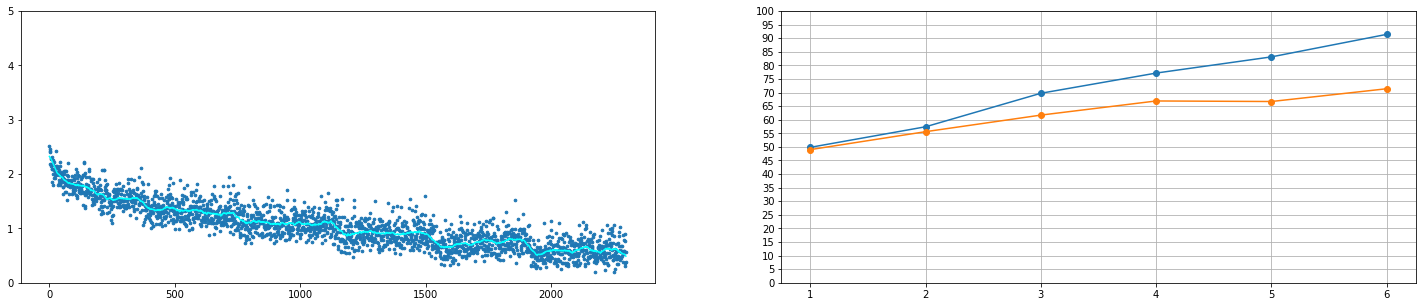

In [37]:
loss_history, train_acc_history, val_acc_history = models_info[sorted_keys[9]][-3::]
plot_model_history(loss_history, train_acc_history, val_acc_history)

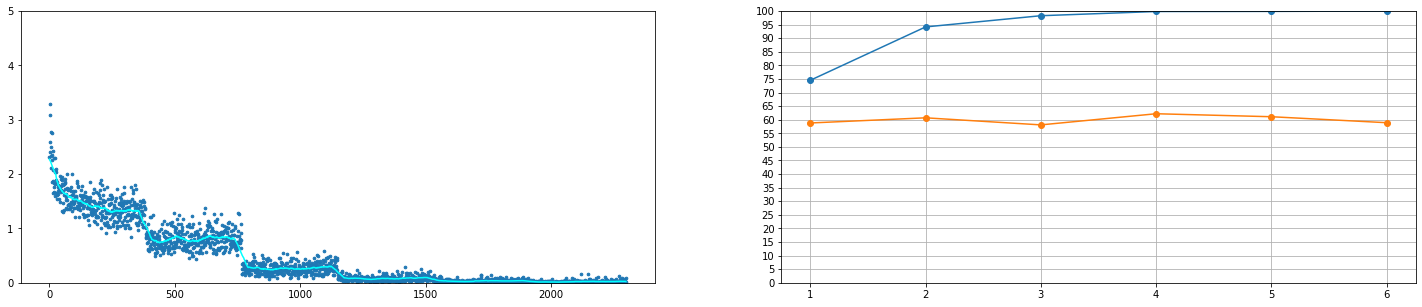

In [38]:
loss_history, train_acc_history, val_acc_history = models_info[sorted_keys[0]][-3::]
plot_model_history(loss_history, train_acc_history, val_acc_history)

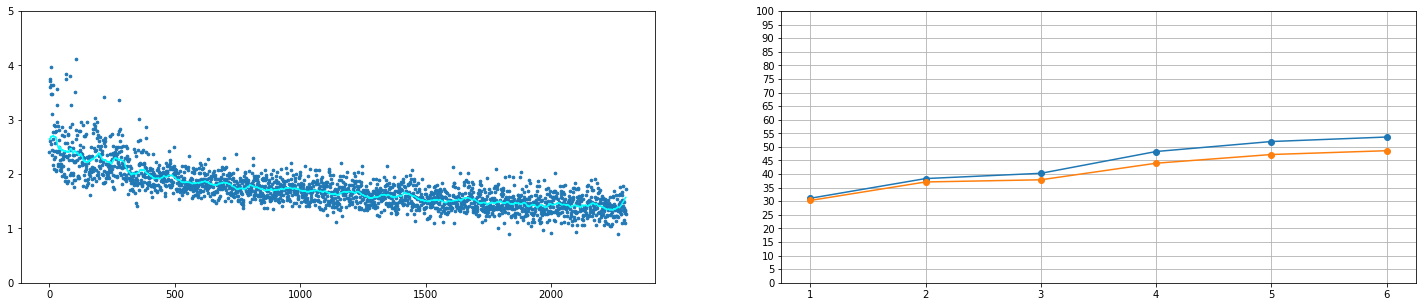

In [41]:
loss_history, train_acc_history, val_acc_history = models_info[sorted_keys[34]][-3::]
plot_model_history(loss_history, train_acc_history, val_acc_history)

In [ ]:
# Выбираем  5 моделей: top2 для каждого типа архитектуры + ful_conv_net
# Разобраться про реализацию регулиризации весов и просто снижения весов
'''
гиперпараметры:
  lr, 
  rg,
  optimizer: 
    Adam (без rg подбирается lr)
    NAG + sheduler
Уменьшить диапазон для lr
'''

In [ ]:
def learning_rate_decay_function(epoch, initial_lr, total_epochs):
  '''
    epoch - текущей номер эпохи (начиная с 0),
    initial_lr - начальная скорость обучения,
    total_epochs - количество эпох обучения.

    функция предназначена для линейного уменьшения скорости обучения: 
      lr = lr0*(1 - epoch/T), 
      где T - общее кол-во эпох, 
  '''
  return initial_lr*(1-epoch/total_epochs)

'''
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: learning_rate_decay_function(step)/lr0)
LambdaLR устанавливаент скорость обучения на каждом шагу как lr0 * lamda_func - lambda_func переданная функция
'''



'\nscheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: learning_rate_decay_function(step)/lr0)\nLambdaLR устанавливаент скорость обучения на каждом шагу как lr0 * lamda_func - lambda_func переданная функция\n'

In [ ]:
class BasicBlock_3x3(nn.Module):
  '''
  [conv(3x3) -> normalization -> activation]x3
  '''
  def __init__(self, input_channels, num_filters, activation_function, normalization = ["BN", 0]):
    super().__init__()

    self.norm2d_1 = None
    self.norm2d_2 = None
    self.norm2d_3 = None

    self.conv2d_1 = nn.Conv2d(in_channels = input_channels, out_channels = num_filters[0], kernel_size = 3) 
    self.conv2d_2 = nn.Conv2d(in_channels = num_filters[0], out_channels = num_filters[1], kernel_size = 3)
    self.conv2d_3 = nn.Conv2d(in_channels = num_filters[1], out_channels = num_filters[2], kernel_size = 3)
    
    self.activation_function = activation_function

    if(normalization[0] == "BN"): # Batch normalization
      self.norm2d_1 = nn.BatchNorm2d(num_features = num_filters[0])
      self.norm2d_2 = nn.BatchNorm2d(num_features = num_filters[1])
      self.norm2d_3 = nn.BatchNorm2d(num_features = num_filters[2])
    
    if(normalization[0] == "GN"): # Group normaliztion
      num_groups = normalization[1] 
      self.norm2d_1 = nn.GroupNorm(num_groups = num_groups, num_channels = num_filters[0])
      self.norm2d_2 = nn.GroupNorm(num_groups = num_groups, num_channels = num_filters[1])
      self.norm2d_3 = nn.GroupNorm(num_groups = num_groups, num_channels = num_filters[2])
       
    if(normalization[0] == "IN"): # Instance normalization (numb of groups = numb of channels)
      self.norm2d_1 = nn.GroupNorm(num_groups = input_channels, num_channels  = num_filters[0])
      self.norm2d_2 = nn.GroupNorm(num_groups = num_filters[0], num_channels  = num_filters[1])
      self.norm2d_3 = nn.GroupNorm(num_groups = num_filters[1], num_channels  = num_filters[2])
    
    # инициализация весов по умолчанию pytorch (отличается от Кайминг Хе)

  def forward(self,x):
    out1 = self.activation_function(self.norm2d_1(self.conv2d_1(x)))
    out2 = self.activation_function(self.norm2d_2(self.conv2d_2(out1)))
    out3 = self.activation_function(self.norm2d_3(self.conv2d_3(out2)))
    return out3

In [ ]:
from numpy.random.mtrand import choice
def get_random_hyperparams(lr_min_max, rg_min_max):
  '''
    Функцифя предназначена для генерации рандомных значений гиперпараметров в заданных интервалах
    lr_min_max - массив диапазона значений min max для скорости обучения
    rg_min_max - массив диапазона значений min max для силы регуляризации L2
  '''
  starting_lr = 10**np.random.uniform(lr_min_max[0],lr_min_max[1])
  reg_strength = 10**np.random.uniform(rg_min_max[0], rg_min_max[1])
  
  normalization_type = np.random.choice(["BN", "GN"])
  channels_per_group = np.random.choice([4,16,32,-1]) # 1 - Instance Norm, -1 => 1 group (Layer Norm)
  normalization = [normalization_type,channels_per_group]
  
  activation_func_type = np.random.choice(["ReLU", "LeakyReLU"])
  activation_func_param = np.random.randint(1,9)**np.random.uniform(-5,-1)
  activation_func = [activation_func_type, activation_func_param ]
  
  return (starting_lr, reg_strength, normalization, activation_func)

In [ ]:
initial_lr0 = 0.01
T = 10
optimizer = optim.SGD(fullConvNet_IN.parameters(), lr = 0.01, weight_decay = 0.001 )
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: learning_rate_decay_function(step, initial_lr0, T)/initial_lr0)

for step in range(10):
    print(step, optimizer.param_groups[0]['lr'], learning_rate_decay_function(step, initial_lr0, T), "sh lr:", scheduler.get_last_lr())
    assert optimizer.param_groups[0]['lr'] == learning_rate_decay_function(step, initial_lr0, T)
    # loss.backward()
    optimizer.step()
    scheduler.step()


0 0.01 0.01 sh lr: [0.01]
1 0.009000000000000001 0.009000000000000001 sh lr: [0.009000000000000001]
2 0.008 0.008 sh lr: [0.008]
3 0.006999999999999999 0.006999999999999999 sh lr: [0.006999999999999999]
4 0.006 0.006 sh lr: [0.006]
5 0.005 0.005 sh lr: [0.005]
6 0.004 0.004 sh lr: [0.004]
7 0.0030000000000000005 0.0030000000000000005 sh lr: [0.0030000000000000005]
8 0.0019999999999999996 0.0019999999999999996 sh lr: [0.0019999999999999996]
9 0.0009999999999999998 0.0009999999999999998 sh lr: [0.0009999999999999998]


In [ ]:
LeakyReLU = nn.LeakyReLU(0.01)
'''
BN -> [BasicBlock_3x3] x 4 -> conv -> BN -> ReLU -> AvgPooling -> FC -> (N,10)
'''
fullConvNet_Avg_pool =  nn.Sequential(
    nn.BatchNorm2d( num_features = 3),
    BasicBlock_3x3(3, [32, 32, 32], LeakyReLU, normalization=["BN",0]), # 32x32 -> 26x26
    BasicBlock_3x3(32, [64, 64, 64], LeakyReLU, normalization=["BN",0]), # 26x26 -> 20x20
    BasicBlock_3x3(64, [128, 128, 128], LeakyReLU, normalization=["BN",0]), # -> 14x14
    BasicBlock_3x3(128, [512, 512, 512 ], LeakyReLU, normalization=["BN",0]), # -> 8x8
    nn.Conv2d(512, 1024, 3), # -> 6x6
    nn.BatchNorm2d(1024), 
    LeakyReLU,
    nn.AvgPool2d(kernel_size = 6, stride = 6, padding = 0), # -> N x 1x1x1024
    Flatten(), # N x 1024
    nn.Linear(1024, 10)
    ).to(device)
  
optimizer = optim.Adam(fullConvNet_Avg_pool.parameters(), lr = 0.01, weight_decay = 0 )
loss_history2, train_acc_history2, val_acc_history2 = training_loop(fullConvNet_Avg_pool, optimizer, loader_train, loader_val, loader_check_train_acc, epochs = 10, verbose = True)

Epoch: 1
train / val acc: 28.50 / 27.90 
Epoch: 2
train / val acc: 43.20 / 40.20 
Epoch: 3
train / val acc: 50.30 / 51.10 
Epoch: 4
train / val acc: 57.50 / 56.60 
Epoch: 5
train / val acc: 59.80 / 60.20 
Epoch: 6
train / val acc: 62.50 / 61.20 
Epoch: 7
train / val acc: 64.70 / 63.80 
Epoch: 8
train / val acc: 69.10 / 66.50 
Epoch: 9
train / val acc: 70.20 / 67.60 
Epoch: 10
train / val acc: 72.80 / 68.40 


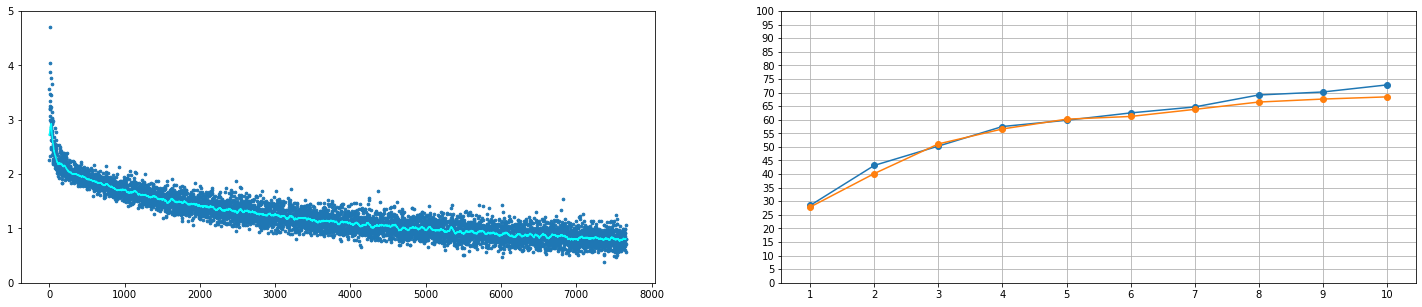

In [ ]:
plot_model_history(loss_history2, train_acc_history2, val_acc_history2)

In [34]:
import matplotlib.pyplot as plt
def plot_model_history(loss_history, train_acc_history, val_acc_history):
  '''
    Функция предназначена для построкения графиков: Loss/iteration, train,val acc  / epoch
  '''
  fig, axs = plt.subplots(1, 2)
  fig.set_figheight(5)
  fig.set_figwidth(25)
  axs[0].set_ylim([0, 5])
  axs[1].set_ylim([0, 100])
  axs[1].set_yticks(np.linspace(0,100,21))
  axs[1].set_xticks(np.linspace(1,10,10))
  axs[1].grid(True)
  axs[0].scatter(np.arange(0,len(loss_history)), loss_history, s = 7)

  #скользящее среднее
  def move_avg(points, window_size):
    a = np.cumsum(points)
    a[window_size:] = a[window_size:] - a[:-window_size]
    return a[window_size-1:]/window_size

  window_size = 51 # неченое
  padding = int((window_size - 1)/2)
  pad_array = np.pad(loss_history, (padding,padding), mode = "edge")
  move_avg_loss = move_avg(pad_array, window_size)

  axs[0].plot(np.arange(0,len(loss_history)), move_avg_loss, "cyan")
  axs[1].plot(np.arange(1,len(train_acc_history)+1), train_acc_history, marker = "o")
  axs[1].plot(np.arange(1,len(val_acc_history)+1), val_acc_history, marker = "o")

## Describe what you did 

В ячейке ниже вы должны написать объяснение того, что вы сделали, любые дополнительные функции, которые вы реализовали, и/или любые графики, которые вы сделали в процессе обучения и оценки вашей сети.

TODO: Describe what you did

## Test set -- run this only once

Теперь, когда мы получили результат, которым мы довольны, мы тестируем нашу окончательную модель на тестовом наборе (которую вы должны сохранить в best_model). Подумайте, как это соотносится с точностью вашего проверочного набора.

In [ ]:

best_model = model
check_accuracy_part34(loader_test, best_model)

NameError: ignored